**MODEL**-CNN-BiLSTM




**OPTIMIZER**-Adam




**LEARNING RATE**-10^-3




**DROPOUT** -0.25



**LSTM LAYER**-100



**ACTIVATION**-relu




**BATCH SIZE**-96




**FILTER**-256 128



In [ ]:
pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
pip install -q -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.9 MB/s eta 0:00:00


In [ ]:
import time
start_time=time.time()

Import necessary libraries


In [ ]:
import warnings
import numpy as np
import pandas as pd
import tensorflow
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Dropout

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


LOAD DATA


In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

One-hot Encoding

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

# create new column weekday
train['weekday'] = np.where(train['date'].dt.dayofweek < 5, 0, 1)
test['weekday'] = np.where(test['date'].dt.dayofweek < 5, 0, 1)
# perform one-hot encoding
train = pd.get_dummies(train, columns=['weekday'])
test = pd.get_dummies(test, columns=['weekday'])

#fill sales data with 0 in test set
test['sales'] = 0


MinMax Scaling

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert the 'date' column to datetime format
train['date'] = pd.to_datetime(train['date'])

# Create weekday and weekend indicator variables based on the 'date' column
train['weekday_weekend'] = np.where(train['date'].dt.weekday < 5, 'weekday', 'weekend')

# Select columns to be scaled
val_cols = ['store', 'item']
num_cols = ['sales']

# Scale the numerical columns using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 200))
train[num_cols] = scaler.fit_transform(train[num_cols])

# Add the 'date', 'store', and 'item' columns back to the dataset
train = train[['date'] + val_cols + num_cols + ['weekday_weekend']]

**Train** data description


In [ ]:
print(train.describe())
print(train.head())

               store           item          sales
count  268166.000000  268166.000000  268166.000000
mean        5.427071       7.850324      48.073547
std         2.855715       4.242138      25.439866
min         1.000000       1.000000       0.000000
25%         3.000000       4.000000      27.705628
50%         5.000000       8.000000      45.887446
75%         8.000000      12.000000      64.069264
max        10.000000      15.000000     200.000000
        date  store  item      sales weekday_weekend
0 2013-01-01      1     1  11.255411         weekday
1 2013-02-01      1     1   9.523810         weekday
2 2013-03-01      1     1  12.121212         weekday
3 2013-04-01      1     1  11.255411         weekday
4 2013-05-01      1     1   8.658009         weekday


In [ ]:
import pandas as pd
# sort the 'date' column in each DataFrame in descending order
train = train.sort_values('date', ascending=True)
test = test.sort_values('date', ascending=True)

# extract the latest date from each DataFrame
train_last_date = train.iloc[-1]['date']
test_last_date = test.iloc[-1]['date']

# convert latest dates to datetime objects and format them as strings
train_last_date = pd.to_datetime(train_last_date).strftime('%Y-%m-%d')
test_last_date = pd.to_datetime(test_last_date).strftime('%Y-%m-%d')

In [ ]:
# Print minimum and maximum date of train set
print("Train set date range: {} to {}".format(train['date'].min(), train['date'].max()))

# Print minimum and maximum date of test set
print("Test set date range: {} to {}".format(test['date'].min(), test['date'].max()))

Train set date range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Test set date range: 2018-01-01 00:00:00 to 2018-12-03 00:00:00


In [ ]:
# print the latest dates and the number of days between them
print("Train last date:", train_last_date)
print("Test last date:", test_last_date)
lag_size = (pd.to_datetime(test_last_date) - pd.to_datetime(train_last_date)).days
print("Number of days between train and test last dates:", lag_size)


Train last date: 2017-12-31
Test last date: 2018-12-03
Number of days between train and test last dates: 337


In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
fig = go.Figure(data=[daily_sales_sc],layout=layout)
fig.show(renderer="colab")

In [ ]:
import plotly.io as pio
pio.renderers.default='notebook'

Reduce training set with the last year alone

In [ ]:
train = train[(train['date'] >= '2017-01-01')]
print(train.head())

             date  store  item      sales weekday_weekend
72675  2017-01-01     10     4  19.047619         weekend
87283  2017-01-01      8     5  19.913420         weekend
242493 2017-01-01      3    14  50.216450         weekend
151193 2017-01-01      3     9  61.471861         weekend
153019 2017-01-01      4     9  45.021645         weekend


Rearrange datasets to apply shift methods


In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,16.450216
1,1,1,2017-01-02,12.987013
2,1,1,2017-01-03,13.852814
3,1,1,2017-01-04,22.510823
4,1,1,2017-01-05,12.987013


Conversion of pandas data into supervised data

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

forecast 90 days with current timesteps


In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+337),store(t+337),sales(t+337)
29,1.0,1.0,16.450216,1.0,1.0,12.987013,1.0,1.0,13.852814,1.0,...,13.852814,1.0,1.0,20.779221,1,1,7.792208,1.0,2.0,19.047619
30,1.0,1.0,12.987013,1.0,1.0,13.852814,1.0,1.0,22.510823,1.0,...,20.779221,1.0,1.0,7.792208,1,1,14.718615,1.0,2.0,27.705628
31,1.0,1.0,13.852814,1.0,1.0,22.510823,1.0,1.0,12.987013,1.0,...,7.792208,1.0,1.0,14.718615,1,1,12.987013,1.0,2.0,35.497835
32,1.0,1.0,22.510823,1.0,1.0,12.987013,1.0,1.0,25.108225,1.0,...,14.718615,1.0,1.0,12.987013,1,1,14.718615,1.0,2.0,21.645022
33,1.0,1.0,12.987013,1.0,1.0,25.108225,1.0,1.0,26.839827,1.0,...,12.987013,1.0,1.0,14.718615,1,1,19.913420,1.0,2.0,35.497835


drop items other than the shifted

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

Remove unwanted columns


In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

train validation split

In [ ]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (29296, 30)
Validation set shape (19532, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
23060,80.519481,95.238095,80.519481,74.458874,46.753247,65.800866,45.887446,41.558442,50.216450,31.168831,...,53.679654,23.376623,38.095238,48.484848,54.545455,57.142857,29.437229,55.411255,73.593074,53.679654
11154,29.437229,19.047619,23.376623,15.584416,27.705628,25.108225,18.181818,11.255411,15.584416,15.584416,...,32.900433,22.510823,19.047619,18.181818,19.047619,19.913420,35.497835,24.242424,34.632035,16.450216
25821,70.995671,36.363636,51.948052,78.787879,82.251082,74.458874,99.567100,118.614719,70.995671,91.774892,...,61.471861,73.593074,86.580087,98.701299,88.311688,62.337662,76.190476,75.324675,56.277056,89.177489
45924,78.787879,77.922078,71.861472,37.229437,44.155844,57.142857,49.350649,63.203463,77.922078,69.264069,...,51.948052,52.813853,63.203463,52.813853,72.727273,50.216450,61.471861,48.484848,71.861472,84.848485
10631,31.168831,24.242424,30.303030,25.108225,42.424242,30.303030,20.779221,32.900433,28.571429,27.705628,...,51.948052,38.095238,47.619048,28.571429,50.216450,47.619048,25.108225,21.645022,27.705628,25.108225


In [ ]:
from keras import optimizers
epochs = 200
batch = 96
lr = 0.001

For CNN parameters(samples,timesteps,features)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (29296, 30, 1)
Validation set shape (19532, 30, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Reshape, TimeDistributed
from keras import optimizers
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='Adam')
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 256)           768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 256)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 50)                179250    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

BiLstm

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_bilstm.add(Dense(1))
model_bilstm.compile(loss='mse', optimizer='adam')
model_bilstm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


CNN-BiLSTM [sample,subsequences,timesteps,features]

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (29296, 2, 15, 1)
Validation set shape (19532, 2, 15, 1)


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, Bidirectional, LSTM, Dense

model_cnn_bilstm = Sequential()
model_cnn_bilstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_bilstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_bilstm.add(TimeDistributed(Flatten()))
model_cnn_bilstm.add(Bidirectional(LSTM(100, activation='relu')))
model_cnn_bilstm.add(Dropout(0.5))
model_cnn_bilstm.add(Dense(1))
model_cnn_bilstm.compile(loss='mse', optimizer='adam',metrics='accuracy')
#model_cnn_bilstm.compile(loss='mse', optimizer= tfa.optimizers.LazyAdam())
model_cnn_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 15, 128)    256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 7, 128)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 896)        0         
 tributed)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              797600    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)              

In [ ]:
cnn_bilstm_history = model_cnn_bilstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/200
916/916 - 42s - loss: 539.6431 - accuracy: 0.0000e+00 - val_loss: 371.1289 - val_accuracy: 0.0000e+00 - 42s/epoch - 45ms/step
Epoch 2/200
916/916 - 23s - loss: 505.5602 - accuracy: 0.0000e+00 - val_loss: 357.1234 - val_accuracy: 0.0000e+00 - 23s/epoch - 25ms/step
Epoch 3/200
916/916 - 24s - loss: 497.3801 - accuracy: 0.0000e+00 - val_loss: 354.4552 - val_accuracy: 0.0000e+00 - 24s/epoch - 26ms/step
Epoch 4/200
916/916 - 26s - loss: 531.3567 - accuracy: 0.0000e+00 - val_loss: 362.6601 - val_accuracy: 0.0000e+00 - 26s/epoch - 28ms/step
Epoch 5/200
916/916 - 25s - loss: 525.7968 - accuracy: 0.0000e+00 - val_loss: 346.4213 - val_accuracy: 0.0000e+00 - 25s/epoch - 27ms/step
Epoch 6/200
916/916 - 26s - loss: 512.6837 - accuracy: 0.0000e+00 - val_loss: 374.2740 - val_accuracy: 0.0000e+00 - 26s/epoch - 28ms/step
Epoch 7/200
916/916 - 26s - loss: 508.3530 - accuracy: 0.0000e+00 - val_loss: 358.0767 - val_accuracy: 0.0000e+00 - 26s/epoch - 28ms/step
Epoch 8/200
916/916 - 26s - loss: 

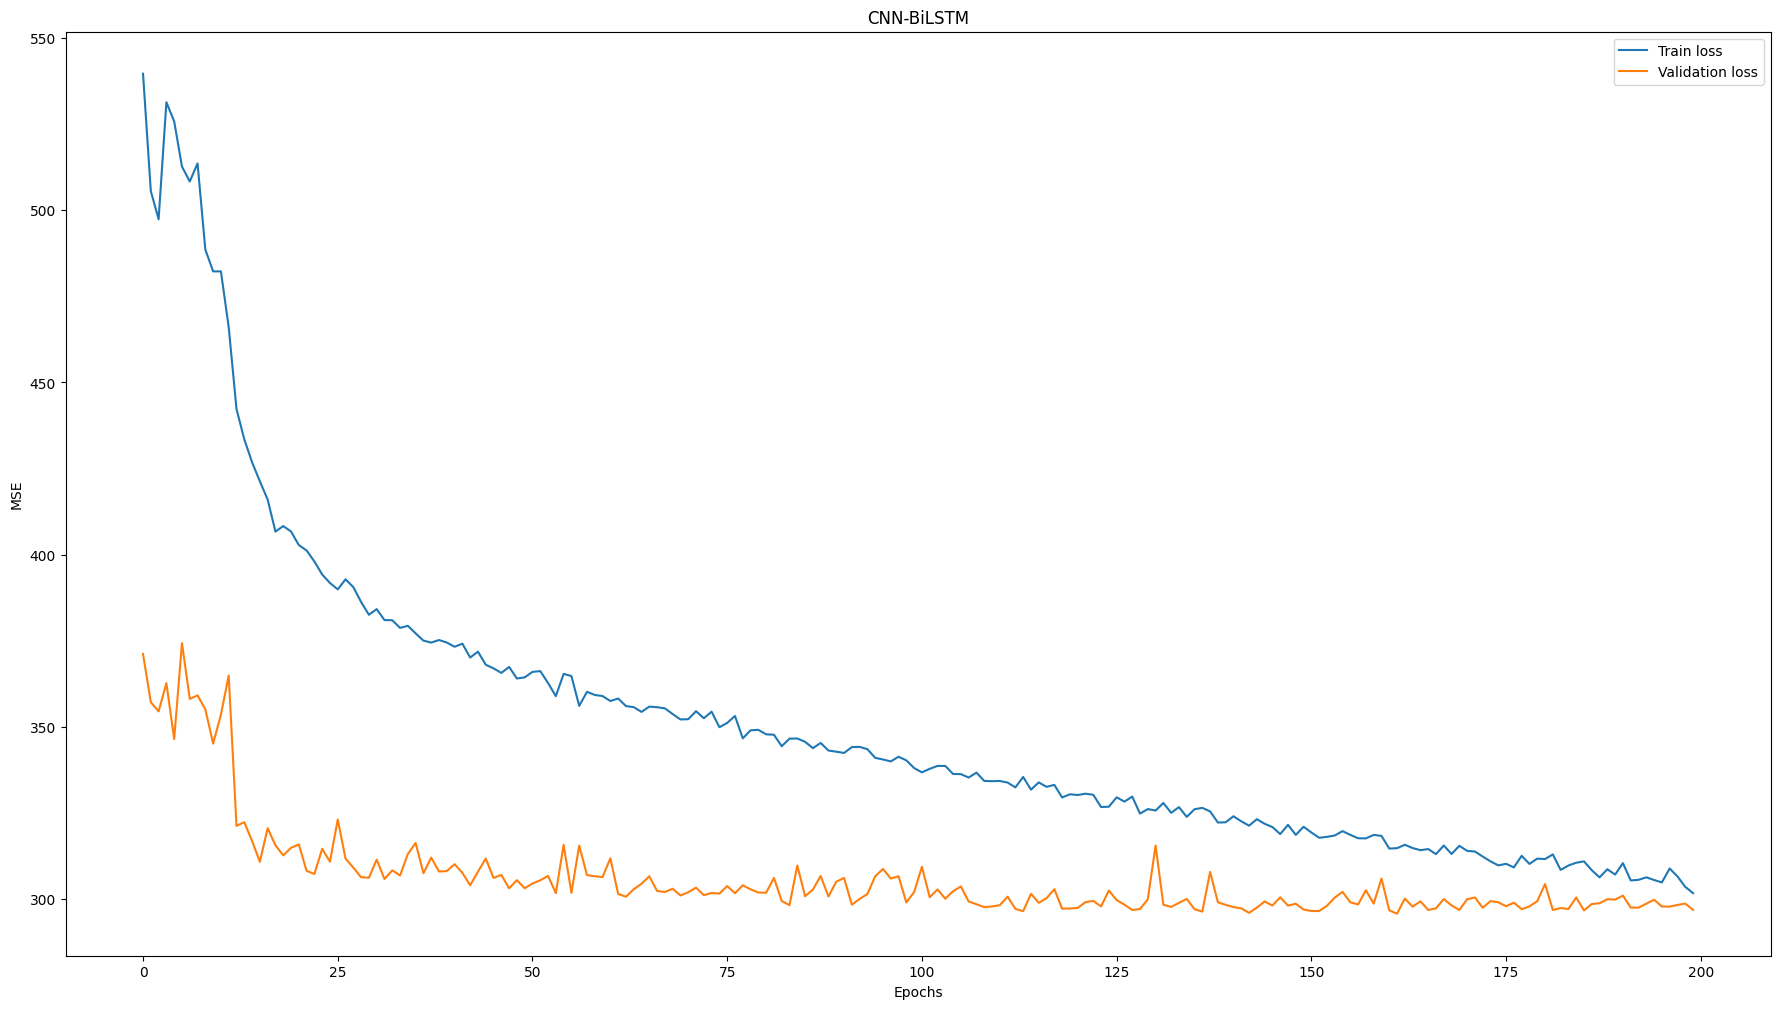

In [ ]:
fig, ax4 = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(22,12))

ax4.plot(cnn_bilstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_bilstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-BiLSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [ ]:
cnn_bilstm_train_pred = model_cnn_bilstm.predict(X_train_series_sub)
cnn_bilstm_valid_pred = model_cnn_bilstm.predict(X_valid_series_sub)
end_time=time.time()

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_bilstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_bilstm_valid_pred)))

611/611 [==============================] - 4s 6ms/step
Train rmse: 16.464985701558103
Validation rmse: 17.22842856886489


Calculating Performance measures

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
mae = mean_absolute_error(Y_train, cnn_bilstm_train_pred)
mape = mean_absolute_percentage_error(Y_train, cnn_bilstm_train_pred) * 100
r2 = r2_score(Y_train, cnn_bilstm_train_pred)
execution_time=end_time-start_time

# Print the results
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.2f}%".format(mape))
print("R-squared: {:.4f}".format(r2))
print("Execution time",execution_time)

MAE: 12.4747
MAPE: 28.61%
R-squared: 0.6575
Execution time 4982.342006921768
